In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install flwr["simulation"] flwr_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.1
    Uninstalling pydantic-2.7.1:
      Successfully uninstalled pydantic-2.7.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobu

In [ ]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

from datasets import Dataset
from flwr_datasets import FederatedDataset

VERBOSE = 0
NUM_CLIENTS = 10
BATCH_SIZE=32

In [ ]:
def preprocess_image(image, label):
    image = image / 255

    return image, label

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def get_model():

    # Load MobileNetV2 model without including the top (fully connected) layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(15, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, valset) -> None:
        # Create model
        self.model = get_model()
        self.trainset = trainset
        self.valset = valset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=2, verbose=VERBOSE)
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.valset, verbose=VERBOSE)
        return loss, len(self.valset), {"accuracy": acc}

In [ ]:
def get_client_fn(dataset: FederatedDataset):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)

        trainset = client_dataset_splits["train"].to_tf_dataset(
            columns="image", label_cols="label", batch_size=BATCH_SIZE
        )
        valset = client_dataset_splits["test"].to_tf_dataset(
            columns="image", label_cols="label", batch_size=BATCH_SIZE
        )
        preprocessed_dataset = trainset.map(preprocess_image)
        preprocessed_dataset = valset.map(preprocess_image)
        # Create and return client
        return FlowerClient(trainset, valset).to_client()

    return client_fn


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset: Dataset):
    """Return an evaluation function for server-side (i.e. centralised) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(testset, verbose=VERBOSE)
        #save weights and model , parameters if rounds is multiple of 10

        return loss, {"accuracy": accuracy}

    return evaluate



In [ ]:
# Enable GPU growth in your main process
# enable_tf_gpu_growth()

# Download MNIST dataset and partition it
fds = FederatedDataset(dataset="GVJahnavi/Plant_village_subset", partitioners={"train": NUM_CLIENTS},shuffle=True, seed=43)
# ds = fds.train_test_split(fds,test_size=0.2,random_state=42)
# fds1 = ds["train"].to_tf_dataset(
#             columns="image", label_cols="label", batch_size=BATCH_SIZE
#         )
# Get the whole test set for centralised evaluation
centralized_testset = fds.load_split("test").to_tf_dataset(
     columns="image", label_cols="label", batch_size=BATCH_SIZE
 )

/usr/local/lib/python3.10/dist-packages/flwr_datasets/utils.py:85: UserWarning: The currently tested dataset are ['mnist', 'cifar10', 'fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet']. Given: GVJahnavi/Plant_village_subset.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/11322 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2916 [00:00<?, ? examples/s]

In [ ]:
preprocessed_dataset = centralized_testset.map(preprocess_image)

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.5,  # Sample 50% of available clients for training
    fraction_evaluate=0.1,  # Sample 10% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 2 clients for training
    min_evaluate_clients=2,  # Never sample less than 1 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 7 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset), # global eDEBUG flwr 2024-03-07 10:11:03,445 | server.py:236 | fit_round 10 received 10 results and 0 failuresvaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 1}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(fds),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    client_resources=client_resources,
    # actor_kwargs={
    #     "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    # },
)

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-26 12:45:28,232	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3946616832.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7893233664.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3946616832.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7893233664.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize y

(ClientAppActor pid=1557) Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
9406464/9406464 [==============================] - 0s 0us/step


INFO :      Received initial parameters from one random client
INFO:flwr:Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO:flwr:Evaluating initial global parameters
INFO :      initial parameters (loss, other metrics): 2.9282279014587402, {'accuracy': 0.05349794402718544}
INFO:flwr:initial parameters (loss, other metrics): 2.9282279014587402, {'accuracy': 0.05349794402718544}
INFO :      
INFO:flwr:
INFO :      [ROUND 1]
INFO:flwr:[ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=1557) WARNING:tensorflow:AutoGraph could not transform <function preprocess_image at 0x79ddd8400e50> and will run it as-is.
(ClientAppActor pid=1557) Cause: Unable to locate the source code of <function preprocess_image at 0x79ddd8400e50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their so

In [ ]:
# # Create FedProx strategy
# strategy = fl.server.strategy.FedProx(
#     fraction_fit=0.5,  # Sample 10% of available clients for training
#     fraction_evaluate=0.1,  # Sample 10% of available clients for evaluation
#     min_fit_clients=5,  # Never sample less than 1 clients for training
#     min_evaluate_clients=2,  # Never sample less than 1 clients for evaluation
#     min_available_clients=int(
#         NUM_CLIENTS * 0.75
#     ),
#     # Wait until at least 3 clients are available
#     evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
#     evaluate_fn=get_evaluate_fn(centralized_testset),
#     proximal_mu = 0.6 # global eDEBUG flwr 2024-03-07 10:11:03,445 | server.py:236 | fit_round 10 received 10 results and 0 failuresvaluation function
# )

# # With a dictionary, you tell Flower's VirtualClientEngine that each
# # client needs exclusive access to these many resources in order to run
# client_resources = {"num_cpus": 1, "num_gpus": 1}

# # Start simulation
# history = fl.simulation.start_simulation(
#     client_fn=get_client_fn(fds),
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=20),
#     strategy=strategy,
#     client_resources=client_resources,
#     # actor_kwargs={
#     #     "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
#     # },
# )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


history.metrics_centralized = {'accuracy': [(0, 0.05349794402718544), (1, 0.7866941094398499), (2, 0.8391632437705994), (3, 0.8600823283195496), (4, 0.8713991641998291), (5, 0.881001353263855), (6, 0.8799725770950317), (7, 0.8974622488021851), (8, 0.903292179107666), (9, 0.8981481194496155), (10, 0.9026063084602356), (11, 0.8998628258705139), (12, 0.9084362387657166), (13, 0.9046639204025269), (14, 0.9036351442337036), (15, 0.9142661094665527), (16, 0.9187242984771729), (17, 0.9122084975242615), (18, 0.9194101691246033), (19, 0.9190672039985657), (20, 0.9204389452934265), (21, 0.9159808158874512), (22, 0.9290123581886292), (23, 0.9207819104194641), (24, 0.9269547462463379), (25, 0.9238682985305786), (26, 0.9180384278297424), (27, 0.9235253930091858), (28, 0.9286693930625916), (29, 0.922153651714325), (30, 0.9149519801139832), (31, 0.9238682985305786), (32, 0.9317558407783508), (33, 0.9118655920028687), (34, 0.9286693930625916), (35, 0.9283264875411987), (36, 0.9266117811203003), (37, 0

Text(0.5, 1.0, 'Plant village subset with 15 classes 50 rounds-5 client per round out of 10 with 2 epochs--MOBILENETV2')

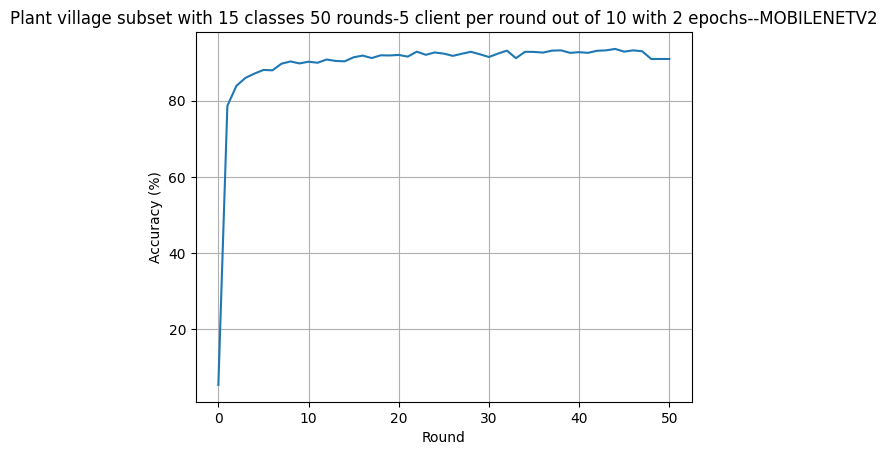

In [ ]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("Plant village subset with 15 classes 50 rounds-5 client per round out of 10 with 2 epochs--MOBILENETV2")